In [72]:
import cv2
import torch
import torchvision
import numpy as np
import copy
import random
from google.colab import drive
from google.colab.patches import cv2_imshow
from torchvision.io.image import read_image
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# print(torchvision.__version__)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# test_img1 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/q1.jpg", cv2.IMREAD_COLOR)
# test_img1 = cv2.resize(test_img1, (800, 600))
# test_img1 = [test_img1, 0.1, 0.5]
# test_img2 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/q2.jpg", cv2.IMREAD_COLOR)
# test_img2 = cv2.resize(test_img2, (800, 600))
# test_img2 = [test_img2, 0.2, 0.1]
# test_img3 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/q5.jpg", cv2.IMREAD_COLOR)
# test_img3 = cv2.resize(test_img3, (800, 600))
# test_img3 = [test_img3, 0.3, 0.6]
# test_img4 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/q6.jpg", cv2.IMREAD_COLOR)
# test_img4 = cv2.resize(test_img4, (800, 600))
# test_img4 = [test_img4, 0.4, 0.3]
# heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart_heart.jpg", cv2.IMREAD_COLOR)
# heart_img = cv2.resize(heart_img, (800, 600))

In [73]:
q1 = np.load("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/test_data0.npy", allow_pickle=True)
q2 = np.load("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/test_data1.npy", allow_pickle=True)
q3 = np.load("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/test_data2.npy", allow_pickle=True)
q4 = np.load("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/test_data3.npy", allow_pickle=True)
q5 = np.load("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/bts_thumb_imgs.npy", allow_pickle=True)
q6 = np.load("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/small_thumb_imgs.npy", allow_pickle=True)


# q1 : 목공 + 요리 + 강아지 + 고양이
# q2 : 목공 + 강아지
# q3 : 요리
# q4 : 여행 + 고양이
# q5 : 목공
# q6 : 여행

In [ ]:
print(len(q1))
print(len(q2))
print(len(q3))
print(len(q4))
print(len(q5))
print(len(q6))

33
29
18
23
54
30


In [ ]:
for i in range(len(q1)):
  cv2_imshow(q1[i][0])
  print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(q2)):
  cv2_imshow(q2[i][0])
  print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(q3)):
  cv2_imshow(q3[i][0])
  print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(q4)):
  cv2_imshow(q4[i][0])
  print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(q5)):
  cv2_imshow(q5[i][0])
  print()

Output hidden; open in https://colab.research.google.com to view.

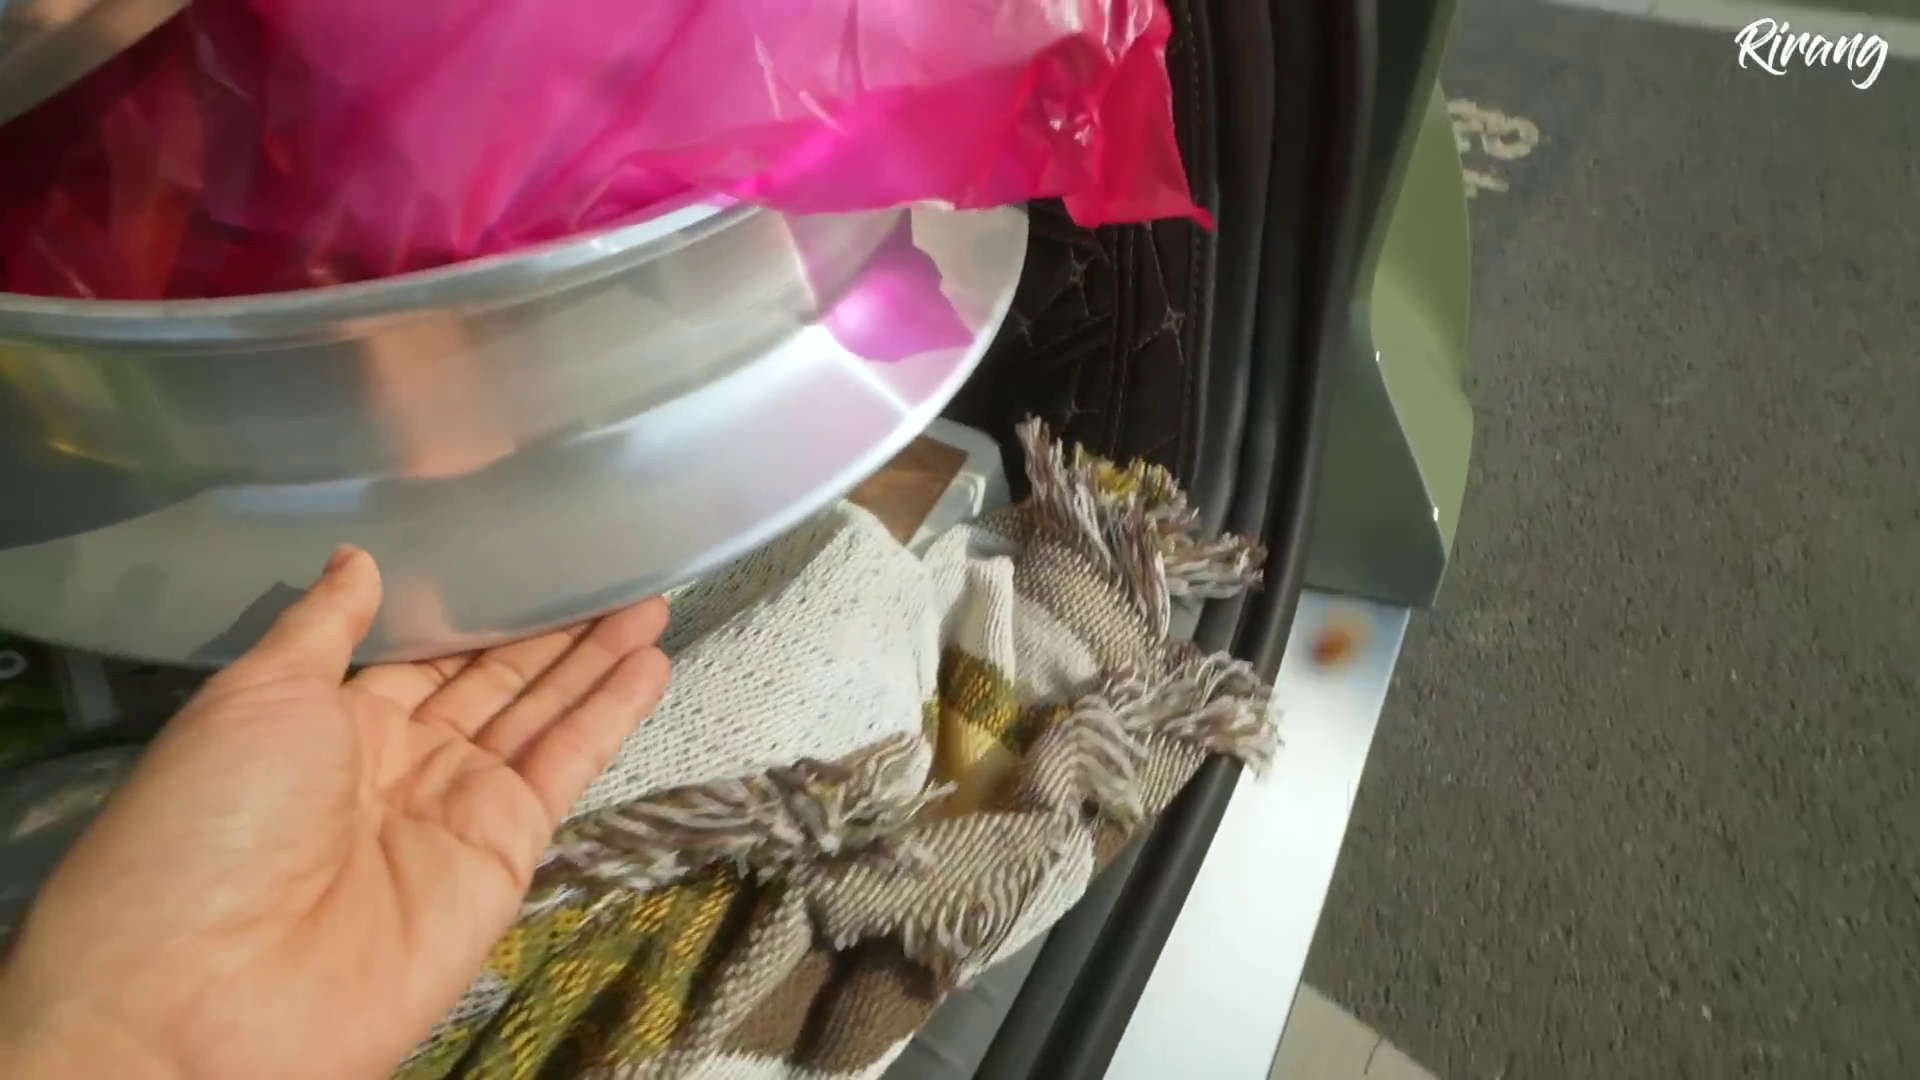

In [ ]:
for i in range(len(q6)):
  cv2_imshow(q6[i][0])
  print()

In [ ]:
# input_data = np.array([test_img1,test_img2, test_img3, test_img4])
# input_data = [test_img1,test_img2, test_img3, test_img4]
# input_data = q[:5].tolist()
# background_img3 = input_data[0]
# background_img4 = input_data[len(input_data) // 2]
# background_img5 = input_data[-1]
# input_data_copy = q.copy()
# input_data.sort(reverse=True, key=lambda x:x[2])   # idx 1은 cps_score, idx 2는 frame_score, frame_score로 정렬
# cps_score : 부분 구간의 중요도 점수
# fps_score : 한 프레임의 중요도 점수

<ipython-input-120-899449013fbf>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_data = np.array([test_img1,test_img2, test_img3, test_img4])


In [ ]:
# for i in input_data:
#     cv2_imshow(i[0])

In [204]:
input_data = q1[16:].tolist()
# input_data = q1[:16].tolist()
# input_data = np.array([q3[2], q3[3], q3[7], q3[8], q3[9], q3[10]]).tolist()

original_height, original_width = input_data[0][0].shape[:2]
original_img_size = original_height * original_width

for i in input_data:
    if i[0].shape[1] > 1200:
        i[0] = cv2.resize(i[0], (None, None), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    elif i[0].shape[1] > 1000:
        i[0] = cv2.resize(i[0], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)


background_img3 = input_data[0]   # 세그먼트할 대상이 없을 경우 사용할 배경(3개 이미지중 첫번째)
background_img4 = input_data[len(input_data) // 2]   # 세그먼트할 대상이 없을 경우 사용할 배경(3개 이미지중 두번째)
background_img5 = input_data[-1]   # 세그먼트할 대상이 없을 경우 사용할 배경(3개 이미지중 세번째)


input_data.sort(reverse=True, key=lambda x:x[2])   # idx 1은 cps_score, idx 2는 frame_score, frame_score로 정렬


background_img1 = input_data.pop()[0]   # 세그먼트할 대상이 있는 경우 사용할 배경
background_img2 = input_data.pop(0)[0]   # 세그먼트할 대상이 없을 경우 사용할 배경(1개 이미지)
tmp_height, tmp_width = input_data[0][0].shape[:2]
tmp_img_size = tmp_height * tmp_width

In [150]:
input_data = [input_data[3], input_data[4]]

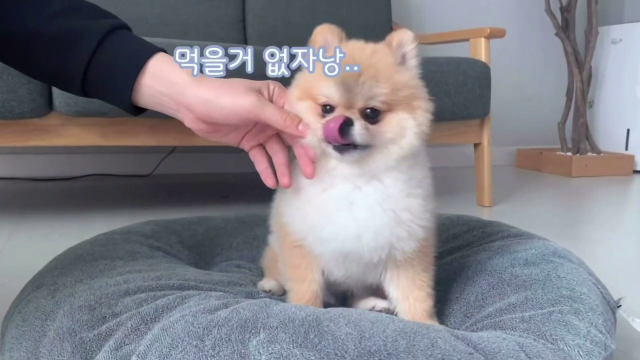

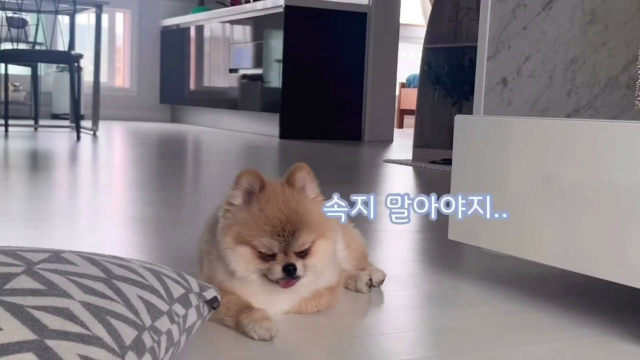

In [151]:
for i in input_data:
    cv2_imshow(i[0])

In [114]:
qwe1 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/test_cat1.jpg", cv2.IMREAD_COLOR)
qwe1 = cv2.resize(qwe1, (input_data[0][0].shape[1], input_data[0][0].shape[0]))
qwe1 = [qwe1, 0.1, 0.5]
input_data.append(qwe1)

qwe2 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/SKT_FLY_AI/project/image/test_dog1.jpg", cv2.IMREAD_COLOR)
qwe2 = cv2.resize(qwe2, (input_data[0][0].shape[1], input_data[0][0].shape[0]))
qwe2 = [qwe2, 0.1, 0.5]
input_data.append(qwe2)

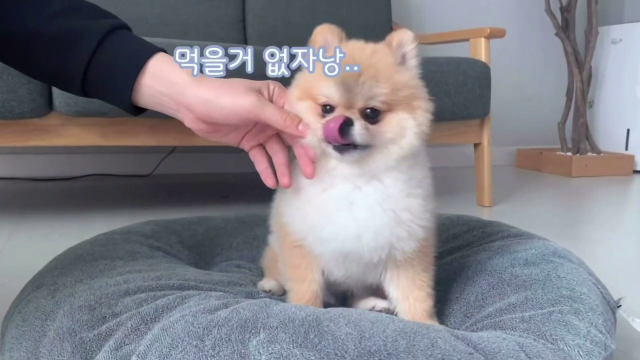

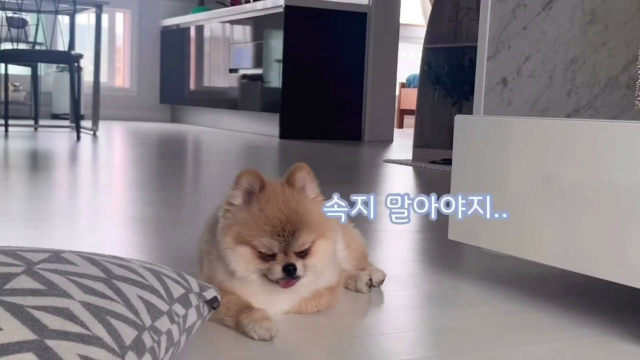

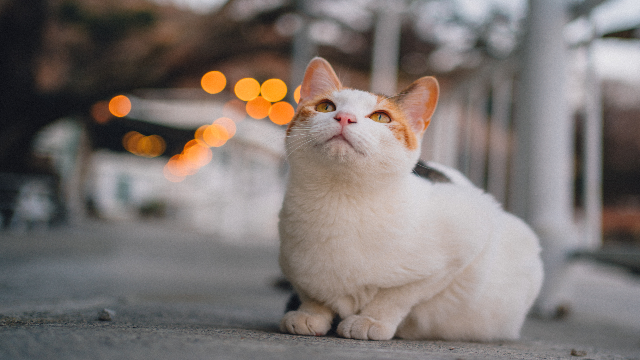

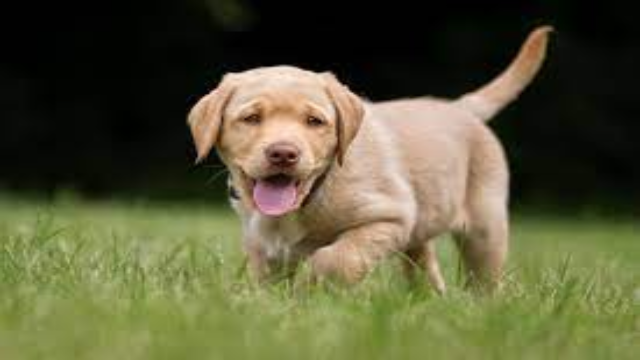

In [115]:
for i in range(len(input_data)):
    cv2_imshow(input_data[i][0])

In [205]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()

model = maskrcnn_resnet50_fpn(weights=weights)
model = model.eval()

In [206]:
input_img_list = []
tt = torchvision.transforms.ToTensor()

for i in range(len(input_data)):
    input_img_list.append(tt(input_data[i][0]))

In [207]:
def make_mask(outputs):
    img_num = len(outputs)
    tmp_dic = {}
    prior_label = [1, 18, 17]
    del_list = []
    real_dic = {}
    score_dic = {}
    proportion = 0.1
    proba_threshold = 0.5
    mask_img = []
    img_case = -1
    

    for i in prior_label:
        real_dic[i] = -1

    for i in prior_label:
        tmp_dic[i] = []


    
    # boxes 버리고 각 이미지에서 레이블 중복되는 거 버림
    for i in range(img_num):
        # del outputs[i]["boxes"]   ##
        outputs[i]["labels"] = outputs[i]["labels"].detach().numpy()
        outputs[i]["scores"] = outputs[i]["scores"].detach().numpy()
        outputs[i]["boxes"] = outputs[i]["boxes"].detach().numpy()
        outputs[i]["masks"] = torch.squeeze(outputs[i]["masks"], 1)
        outputs[i]["masks"] = outputs[i]["masks"].detach().numpy()
        del_idx = []

        for j in range(1, len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in outputs[i]["labels"][:j]:
                del_idx.append(j)


        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)
        outputs[i]["boxes"] = np.delete(outputs[i]["boxes"], del_idx, axis=0)
        outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], -1)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)


    # # 단순 출력용도
    # for i in range(img_num):
    #     print(i)
    #     for j in range(len(outputs[i]["labels"])):
    #         print(outputs[i]["labels"][j], end=" ")
    #     print()
    #     for j in range(len(outputs[i]["scores"])):
    #         print(outputs[i]["scores"][j], end=" ")
    #     print()    
    # print()
    # print()


    # tmp_dic에 레이블당 score가 가장 높은 애들을 저장   ###
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in prior_label:
                tmp_dic[outputs[i]["labels"][j]].append(outputs[i]["scores"][j])
                    

    print(1, tmp_dic, "\n\n")   #########################

    for i in list(tmp_dic.keys()):
        del_list = []
        for j in tmp_dic[i]:
            if j < 0.95:
                del_list.append(j)

        for d in del_list:
            tmp_dic[i].remove(d)

        tmp_dic[i].sort(reverse=True)
    
    print(2, tmp_dic, "\n\n")   #########################
    

    if len(tmp_dic[1]) != 0:   # 사람 O
        if len(tmp_dic[18]) == 0 and len(tmp_dic[17]) == 0:   # 사람 O, 개나 고양이 X
            img_case = 1
            while len(tmp_dic[1]) > 3:
                tmp_dic[1].pop()
        else:   # 사람 O, 개나 고양이 O
            img_case = 2
            if len(tmp_dic[18]) != 0:
                tmp_dic[18] = [max(tmp_dic[18])]
            if len(tmp_dic[17]) != 0:
                tmp_dic[17] = [max(tmp_dic[17])]
            while len(tmp_dic[1]) > 2:
                tmp_dic[1].pop()

    else:   # 사람 X
        if len(tmp_dic[18]) == 0 and len(tmp_dic[17]) == 0:   # 사람 X, 개나 고양이 X
            img_case = 4
        else:   # 사람 X, 개나 고양이 O
            img_case = 3
            while len(tmp_dic[18]) > 2:
                tmp_dic[18].pop()
            while len(tmp_dic[17]) > 2:
                tmp_dic[17].pop()
            while len(tmp_dic[18] + tmp_dic[17]) < 2:
                min_tmp = tmp_dic[18] + tmp_dic[17]
                if min_tmp in tmp_dic[17]:
                    tmp_dic[17].remove(min_tmp)
                else:
                    tmp_dic[18].remove(min_tmp)

    # print(tmp_dic, "\n\n")   #########################
    print(3, tmp_dic, "\n\n")



    ###################3
    for i in range(len(outputs)):
        print(1)
        print(i + 1)
        print(outputs[i]["labels"])
        print(outputs[i]["masks"].shape)
        print(outputs[i]["scores"])
        print("\n\n")
            

    # 레이블당 score가 가장 높은 애들을 제외하고 나머지는 삭제
    for i in range(img_num):
        del_idx = []
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in tmp_dic.keys():
                if outputs[i]["scores"][j] not in tmp_dic[outputs[i]["labels"][j]]:
                    del_idx.append(j)
            else:
                del_idx.append(j)
        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)
        outputs[i]["boxes"] = np.delete(outputs[i]["boxes"], del_idx, axis=0)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)
        outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], tmp_height, tmp_width)



    ###################3
    for i in range(len(outputs)):
        print(2)
        print(i + 1)
        print(outputs[i]["labels"])
        print(outputs[i]["masks"].shape)
        print(outputs[i]["scores"])
        print("\n\n")


    
    # outputs.sort(key=lambda x: (x["labels"], x["scores"] if len(x["labels"]) != 0 else x["labels"] = -1), reverse=True)
    # outputs.sort(key=lambda x: (x["labels"], -x["scores"]))




    ###################3
    for i in range(len(outputs)):
        print(3)
        print(i + 1)
        print(outputs[i]["labels"])
        print(outputs[i]["masks"].shape)
        print(outputs[i]["scores"])
        print("\n\n")


    
    
    # 사용안 할 이미지는 리스트에서 삭제
    tmp_idx = []
    tmp_outputs = []
    tmp_input_data = []
    for i in range(img_num):
        if len(outputs[i]["labels"]) != 0:
            tmp_idx.append(i)

    for i in tmp_idx:
        tmp_outputs.append(outputs[i])
        tmp_input_data.append(input_data[i][0].copy())

    outputs = tmp_outputs
    input_data_img = tmp_input_data
    



    ###################3
    for i in range(len(outputs)):
        print(4)
        print(i + 1)
        print(outputs[i]["labels"])
        print(outputs[i]["masks"].shape)
        print(outputs[i]["scores"])
        print(outputs[i]["boxes"])
        print("\n\n")





    


    # # 단순 출력용도
    # for i in range(img_num):
    #     print(i)
    #     for j in range(len(outputs[i]["labels"])):
    #         print(outputs[i]["labels"][j], end=" ")
    #     print()
    #     for j in range(len(outputs[i]["scores"])):
    #         print(outputs[i]["scores"][j], end=" ")
    #     print()    
    # print()
    # print()


    # for i in range(img_num):
    #     for j in range(len(outputs[i]["labels"])):
    #         if outputs[i]["labels"][j] in real_dic.keys():
    #             real_dic[outputs[i]["labels"][j]] = i

    # for i in real_dic.keys():
    #     if real_dic[i] == -1:
    #         del_list.append(i)

    # for i in del_list:
    #     del real_dic[i]

    # del_list = []

    # score_dic = dict(sorted(score_dic.items(), key=lambda x: x[1], reverse=True))

    # for i in score_dic.keys():
    #     if score_dic[i] < 0.7:
    #         del_list.append(i)

    # for i in del_list:
    #     del score_dic[i]
    
    # for i in range(img_num):
    #     for j in range(len(outputs[i]["labels"])):
    #         if outputs[i]["labels"][j] in score_dic.keys():
    #             score_dic[outputs[i]["labels"][j]] = i

    # real_dic.update(score_dic)

    # while len(real_dic.keys()) > 8:
    #     del real_dic[list(real_dic.keys())[-1]]


    # outputs에서 사용할 label, score, mask 빼고 다 삭제
    # for i in range(img_num):
    #     del outputs[i]["scores"]
    #     del_idx = []

    #     for j in range(len(outputs[i]["labels"])):
    #         if outputs[i]["labels"][j] not in real_dic.keys():
    #             del_idx.append(j)

    #     outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
    #     outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)

    # tmp_l = list(real_dic.values())

    for i in range(len(outputs)):
        for j in range(len(outputs[i]["labels"])):
            outputs[i]["masks"][j] = np.where(outputs[i]["masks"][j] < 0.25, 0, 255)
            dst = input_data_img[i].copy()
            dst = cv2.bitwise_and(dst, dst, mask=outputs[i]["masks"][j].astype("uint8"))
            mask_img.append(dst)

    # print("8888888888888888")
    # print(outputs[0]["boxes"])


    result = [(a, b) for a, b in zip(outputs, mask_img)]
    result.sort(key=lambda x: (x[0]["labels"], ((x[0]["boxes"][0][2] - x[0]["boxes"][0][0]) / (x[0]["boxes"][0][3] - x[0]["boxes"][0][1]))))

    mask_img = [a[1] for a in result]

    ###################3
    for i in range(len(result)):
        print(5)
        print(i + 1)
        print(result[i][0]["labels"])
        print(result[i][0]["masks"].shape)
        print(result[i][0]["scores"])
        print(result[i][0]["boxes"])
        print("\n\n")


    # while len(mask_img) != len(real_dic.keys()):
    #     for i in range(img_num):
    #         if i == tmp_l[0]:
    #             outputs[i]["masks"][0] = np.where(outputs[i]["masks"][0] < 0.25, 0, 255)
    #             dst = input_data[i][0].copy()
    #             dst = cv2.bitwise_and(dst, dst, mask=outputs[i]["masks"][0].astype("uint8"))
    #             mask_img.append(dst)
    #             tmp_l.pop(0)
    #             break

    #     outputs[i]["masks"] = np.delete(outputs[i]["masks"], 0, axis=0)
    
    return real_dic, img_case, mask_img   # real_dic 삭제하기

In [208]:
# r = {}
# r[0] = [1, 2]
# r[1] = [3]
# r[2] = [4]

# v = []
# for k in r.keys():
#     v += r[k]
# print(v)

# v = [a for a in r.values()]
# v = sum(v, [])
# print(v)

In [209]:
def make_thumbnail_fg(mask_img):
    img_list = []
    mask_img_copy = mask_img

    for i in range(len(mask_img)):
        tmp = cv2.cvtColor(mask_img[i], cv2.COLOR_BGR2GRAY)
        _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)

        for j in range(1, cnt):
            (x, y, w, h, area) = stats[j]

            if area / tmp_img_size < 1 / 20:
                tmp[y:y+h, x:x+w] = 0
            
        a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(a) != 0:
            cv2.drawContours(mask_img_copy[i], a, -1, (255, 255, 255), 11)
            tmp = cv2.bitwise_and(mask_img_copy[i], mask_img_copy[i], mask=tmp)
            img_list.append(tmp)
        

    for i in range(len(img_list)):
        tmp = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY)
        _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)
        (x, y, w, h, area) = stats[1]

        m = np.float32([[1, 0, -x], [0, 1, -y]])

        img_list[i] = cv2.warpAffine(img_list[i], m, (0, 0))

        if i == 0:
            if area / tmp_img_size > 1/ 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.65, fy=0.65, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.75, fy=0.75, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.85, fy=0.85, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.95, fy=0.95, interpolation=cv2.INTER_AREA)
            else:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
        elif i == 1:
            if area / tmp_img_size > 1/ 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.8, fy=0.8, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.9, fy=0.9, interpolation=cv2.INTER_AREA)
            else:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)

        elif i == 2 or i == 3:
            if area / tmp_img_size > 1/ 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.35, fy=0.35, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.45, fy=0.45, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1/ 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.85, fy=0.85, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size < 1 / 25:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
        else:
            if area / tmp_img_size >= 1 / 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 15:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 20:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size < 1 / 30:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.1, fy=1.1, interpolation=cv2.INTER_LINEAR)
    

    ####################
    # while len(img_list) < 6:
    #     heart_img = cv2.cvtColor(heart_img, cv2.COLOR_BGR2HSV)
    #     heart_img_copy = heart_img.copy()

    #     tmp = cv2.cvtColor(heart_img, cv2.COLOR_BGR2GRAY)
    #     _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

    #     # a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #     # cv2.drawContours(heart_img_copy, a, -1, (255, 255, 255), 11)

    #     # heart_img = cv2.bitwise_and(heart_img_copy, heart_img_copy, mask=tmp)

    #     cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)

    #     area_sum = 0

    #     for i in range(1, cnt):
    #         (x, y, w, h, area) = stats[i]
    #         area_sum += area

    #     if area_sum / tmp_img_size >= 1 / 2:
    #             heart_img = cv2.resize(heart_img, (None, None), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 3:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.35, fy=0.35, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 6:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.45, fy=0.45, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 10:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.55, fy=0.55, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 15:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.65, fy=0.65, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 20:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.75, fy=0.75, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size < 1 / 30:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=1.1, fy=1.1, interpolation=cv2.INTER_LINEAR)
            
    #     # a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #     # cv2.drawContours(heart_img_copy, a, -1, (255, 255, 255), 11)

    #     # heart_img = cv2.bitwise_and(heart_img_copy, heart_img_copy, mask=tmp)

    #     img_list.append(heart_img)


    for i in range(len(img_list)):
        bg = np.zeros((tmp_height, tmp_width, 3), dtype=np.uint8)

        if img_list[i].shape[0] > bg.shape[0]:
            bg[:bg.shape[0], :bg.shape[1]] = img_list[i][:bg.shape[0], :bg.shape[1]]
        else:
            bg[:img_list[i].shape[0], :img_list[i].shape[1]] = img_list[i]

        img_list[i] = bg


    pos_dic = {}

    for i in range(len(img_list)):
        tmp = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY)
        _, tmp = cv2.threshold(tmp, 1, 255, cv2.THRESH_BINARY)

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)
        centroids = centroids.astype(np.int64)
        (x, y, w, h, area) = stats[1]
        pos_dic[i] = [x, y, w, h, area, (centroids[1][0], centroids[1][1])]

        if i == 0:
            shift_x = 10
            shift_y = tmp_height - h

        elif i == 1:
            shift_x = tmp_width - w - 10
            shift_y = tmp_height - h
        
        elif i == 2:
            shift_x = pos_dic[0][2] + 10
            shift_y = tmp_height - pos_dic[0][3] - int(h / 3)

        elif i == 3:
            shift_x = tmp_width - w - 10
            shift_y = tmp_height - pos_dic[1][3] - h - 10

        else:
            if i == 4:
                shift_x = 20
                shift_y = 20
            else:
                # shift_x = pos_dic[0][2] + pos_dic[2][2] + 20
                # shift_x = (pos_dic[2][2] + pos_dic[4][2]) * int(1 + i / 10)
                # shift_y = pos_dic[i - 1][3] - int(pos_dic[i][3] / 2)
                shift_x = int(tmp_width / (15 - i) * i)
                shift_y += int(pos_dic[i][3] / 3)


        m = np.float32([[1, 0, int(shift_x)], [0, 1, int(shift_y)]])
        img_list[i] = cv2.warpAffine(img_list[i], m, (0, 0))


    dst1 = np.zeros((tmp_height, tmp_width, 3), np.uint8)

    for i in img_list[::-1]:
        # dst2 = cv2.add(dst2, i)
        # dst2 = cv2.bitwise_or(dst2, i)

        gray_tmp = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_tmp, 0.1, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        masked_fg = cv2.bitwise_and(i, i, mask=mask)
        masked_bg = cv2.bitwise_and(dst1, dst1, mask=mask_inv)

        dst1 = masked_fg + masked_bg

    return dst1

In [210]:
def make_thumbnail_bg(dst1, bg_image=True, bg_c="sky", text_f="TRIPLEX", text_c="black",text="VLOG", font_scale=2, font_thickness=2):
    bg_color = {"sky": cv2.merge([np.full((tmp_height, tmp_width), 255, np.uint8), np.full((tmp_height, tmp_width), 204, np.uint8), np.full((tmp_height, tmp_width), 153, np.uint8)]),
            "pink": cv2.merge([np.full((tmp_height, tmp_width), 255, np.uint8), np.full((tmp_height, tmp_width), 51, np.uint8), np.full((tmp_height, tmp_width), 255, np.uint8)]),
            "red": cv2.merge([np.full((tmp_height, tmp_width), 0, np.uint8), np.full((tmp_height, tmp_width), 0, np.uint8), np.full((tmp_height, tmp_width), 255, np.uint8)]),
            }
    text_color = {"black": (0, 0, 0), "red": (0, 0, 255), "blue": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}
    text_font = {"SIMPLEX": cv2.FONT_HERSHEY_SIMPLEX, "TRIPLEX": cv2.FONT_HERSHEY_TRIPLEX, "ITALIC": cv2.FONT_ITALIC}

    if bg_image:
        dst2 = background_img1
    else:
        dst2 = bg_color[bg_c]

    text_size = cv2.getTextSize(text, text_font[text_f], font_scale, font_thickness)[0]
    text_x = int((dst2.shape[1] - text_size[0]) / 2)
    text_y = int((dst2.shape[0] - text_size[1]) / 4 * 3)
    dst1_gray = cv2.cvtColor(dst1, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(dst1_gray, 0.1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    masked_fg = cv2.bitwise_and(dst1, dst1, mask=mask)
    masked_bg = cv2.bitwise_and(dst2, dst2, mask=mask_inv)
    dst = masked_fg + masked_bg
    # dst = dst2 + masked_bg

    cv2.putText(dst, text, (text_x, text_y), text_font[text_f], font_scale, text_color[text_c], font_thickness)

    return dst

In [211]:
torch_img_list = [transform(tmp) for tmp in input_img_list]

with torch.no_grad():
    outputs = model(torch_img_list)
# outputs = model(torch_img_list)

In [ ]:
print(outputs[0]["boxes"].shape)
print(outputs[0]["boxes"][0])
print(outputs[0]["scores"].shape)

torch.Size([78, 4])
tensor([ 62.4131, 249.5583, 213.4602, 341.1035])
torch.Size([78])


In [ ]:
for i in range(len(outputs)):
    print(i + 1)
    print(outputs[i]["labels"])
    print(outputs[i]["masks"].shape)
    print(outputs[i]["scores"])
    print(outputs[i]["boxes"])
    print("\n\n")

1
tensor([18, 64, 86, 62, 64, 44, 44, 64, 67, 62, 86, 63, 17, 86, 82, 62, 62, 38,
        84, 62, 84, 62, 86, 62, 84, 64, 62, 64, 62, 36, 67, 86, 67, 72, 62, 62,
        67, 62, 64, 62, 62, 84, 44, 67, 67, 62, 35, 62, 51, 90, 67, 44, 62, 67,
        67, 67])
torch.Size([56, 1, 360, 640])
tensor([0.9716, 0.9612, 0.9330, 0.8226, 0.7520, 0.6856, 0.6380, 0.5524, 0.5254,
        0.5176, 0.3834, 0.3096, 0.2876, 0.2677, 0.2404, 0.2380, 0.2243, 0.2109,
        0.1906, 0.1707, 0.1528, 0.1370, 0.1334, 0.1304, 0.1211, 0.1125, 0.1072,
        0.1045, 0.1041, 0.1039, 0.1009, 0.1001, 0.0954, 0.0943, 0.0925, 0.0916,
        0.0902, 0.0841, 0.0827, 0.0792, 0.0787, 0.0735, 0.0715, 0.0714, 0.0674,
        0.0628, 0.0625, 0.0611, 0.0608, 0.0603, 0.0564, 0.0563, 0.0545, 0.0520,
        0.0520, 0.0519])
tensor([[284.9592,  70.4233, 441.6300, 338.6000],
        [  0.0000,   3.4569,  97.4919,  84.8421],
        [ 23.0325,  64.2423,  49.2171,  78.3491],
        [420.3795,  77.4894, 470.4022, 161.5259],
      

In [212]:
tmp_outputs = []
tmp_input_data = []

for i in range(len(outputs)):
    if len(outputs[i]["labels"]) != 0:
        tmp_outputs.append(outputs[i])
        tmp_input_data.append(input_data[i])

outputs = tmp_outputs
input_data = tmp_input_data

In [99]:
for i in range(len(outputs)):
    print(i + 1)
    print(outputs[i]["labels"])
    print(outputs[i]["masks"].shape)
    print(outputs[i]["scores"])
    print(outputs[i]["boxes"].shape)
    print("\n\n")

1
[18]
(1, 360, 640)
[0.97160316]
(1, 4)



2
[]
(0, 360, 640)
[]
(0, 4)



3
[]
(0, 360, 640)
[]
(0, 4)



4
[]
(0, 360, 640)
[]
(0, 4)



5
[17]
(1, 360, 640)
[0.9909281]
(1, 4)



6
[1]
(1, 360, 640)
[0.99957246]
(1, 4)



7
[]
(0, 360, 640)
[]
(0, 4)



8
[]
(0, 360, 640)
[]
(0, 4)



9
[]
(0, 360, 640)
[]
(0, 4)



10
[]
(0, 360, 640)
[]
(0, 4)



11
[1]
(1, 360, 640)
[0.99825233]
(1, 4)



12
[]
(0, 360, 640)
[]
(0, 4)



13
[]
(0, 360, 640)
[]
(0, 4)





In [ ]:
len(input_data)

13

In [213]:
real_dic, img_case, mask_img = make_mask(outputs)

1 {1: [0.9976636, 0.9963761, 0.7824603, 0.13116264, 0.99957246, 0.1207605, 0.99569136, 0.1612637, 0.99825233], 18: [0.97160316, 0.7247401, 0.40843138, 0.51512367, 0.1117055], 17: [0.28757805, 0.5381784, 0.9909281, 0.98842585, 0.5780056, 0.42013732, 0.97864425, 0.98636276]} 


2 {1: [0.99957246, 0.99825233, 0.9976636, 0.9963761, 0.99569136], 18: [0.97160316], 17: [0.9909281, 0.98842585, 0.98636276, 0.97864425]} 


3 {1: [0.99957246, 0.99825233], 18: [0.97160316], 17: [0.9909281]} 


1
1
[18 64 86 62 44 67 63 17 82 38 84 36 72 35 51 90]
(16, 230400)
[0.97160316 0.9612389  0.93303967 0.82259774 0.68561655 0.52535737
 0.30960357 0.28757805 0.24038097 0.2108779  0.19055991 0.10390148
 0.09432802 0.06245416 0.060848   0.06034938]



1
2
[46  1 62 44 81 67 28 16 32 50 51 89 86 65 48 63 87 49 47 31]
(20, 230400)
[0.9990645  0.9976636  0.83062154 0.7718698  0.42690215 0.42470783
 0.2638975  0.21201245 0.16474988 0.15160434 0.13344404 0.11328112
 0.10939121 0.09487198 0.08697131 0.08205008 0.071

In [ ]:
img_case

2

In [ ]:
real_dic

{1: -1, 18: -1, 17: -1}

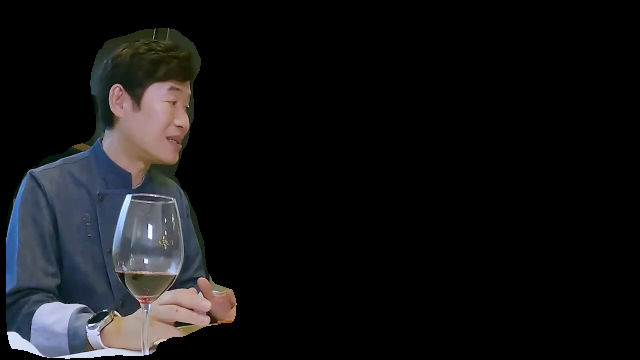

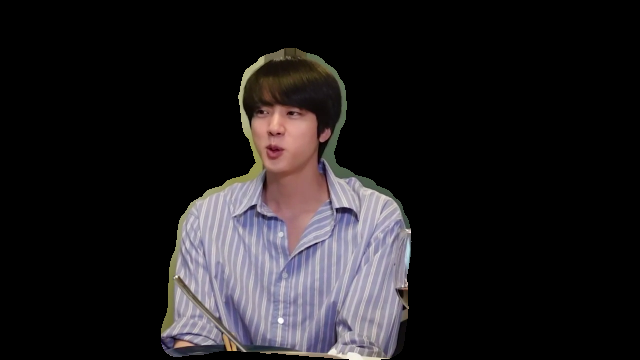

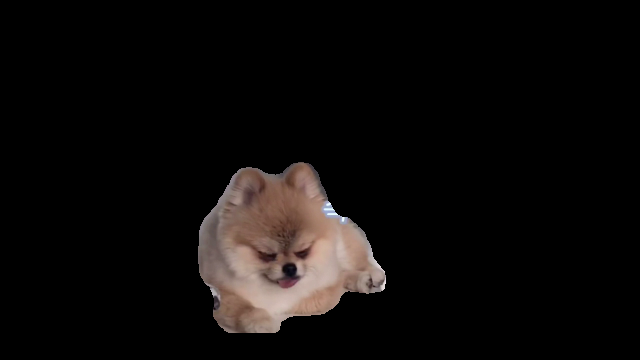

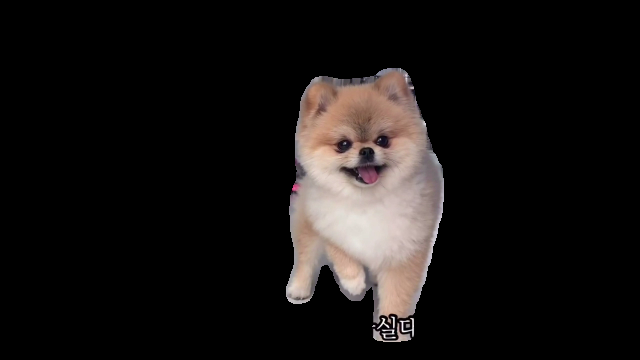

In [214]:
for i in mask_img:
    cv2_imshow(i)
    print()
    

In [ ]:
len(mask_img)

3

In [215]:
dst1 = make_thumbnail_fg(mask_img)

In [216]:
dst2 = make_thumbnail_bg(dst1, bg_image=True, bg_c="sky", text_f="TRIPLEX", text_c="black", text="QWE's VLOG", font_scale=2, font_thickness=2)

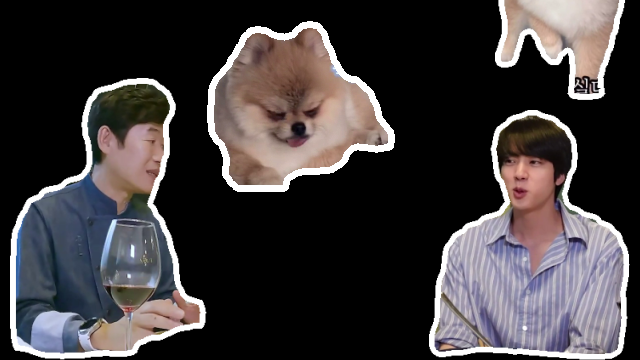

In [217]:
cv2_imshow(dst1)

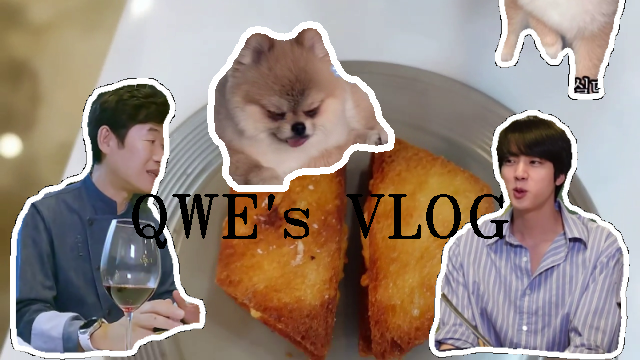

In [218]:
cv2_imshow(dst2)

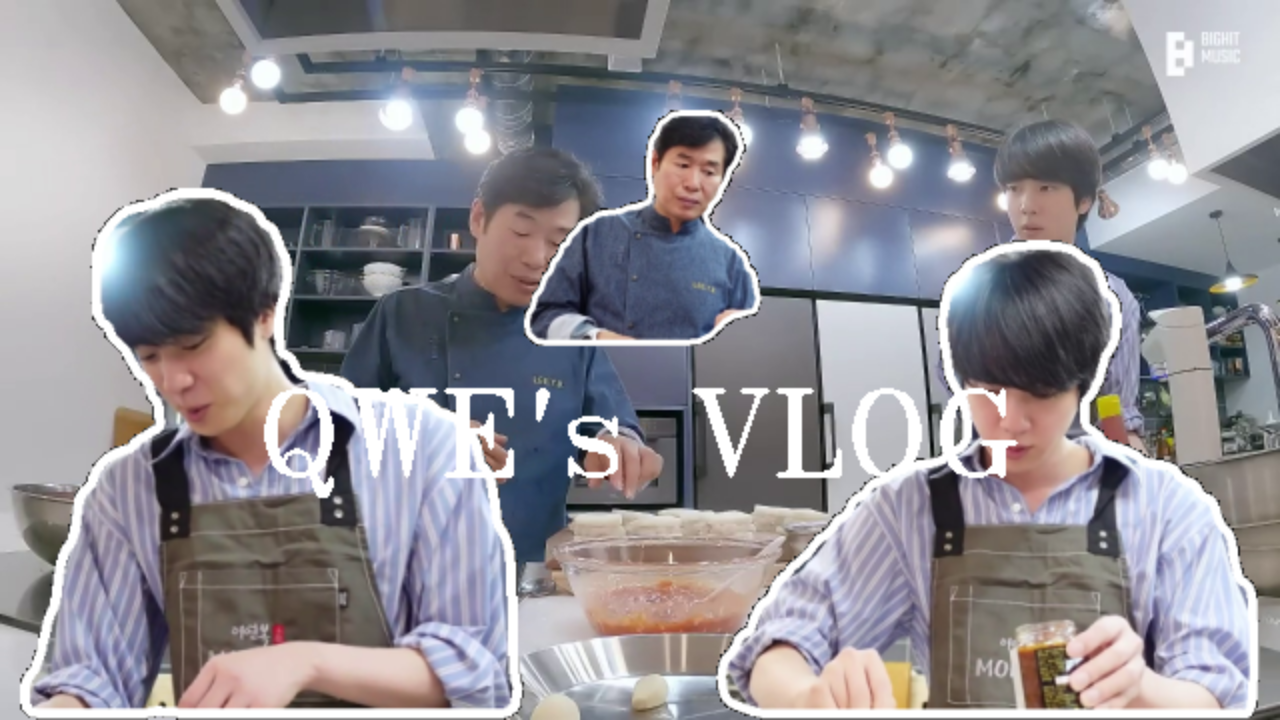

In [ ]:
dst = cv2.resize(dst2, (original_width, original_height))
cv2_imshow(dst)

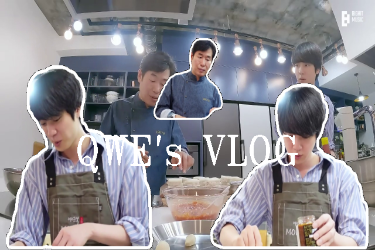

In [ ]:
dst = cv2.resize(dst2, (375, 250))
cv2_imshow(dst)

In [ ]:
# cv2.FONT_HERSHEY_TRIPLEX | cv2.FONT_ITALIC